## Try to see if the model can be stable with $ D_{\text{EC},\text{e}}^0 = \, 1.5 \times 10^{-10} \, \text{m}^2/\text{s} $
### $ D_{\text{e},\text{EC}}^0 = 1.0 \times 10^{-10} \, \text{m}^2/\text{s} $ and also the single case 

### Conclusion: this notebook shows that by making $ D_{\text{EC},\text{e}}^0 = \, 1.5 \times 10^{-10} \, \text{m}^2/\text{s} $, the model can do 2C discharge in 31 seconds, compared with making it "thermodynamic consistent" but the model struggle to do 1.85 discharge (takes 30 minutes, and terminal at 2.7 V instead of the preset 2.5V because the EC related flux goes crazy.) --> But if we do that, that will be the same as our previous version post in arXiv.

In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'Rate_Performance_Debug_EC/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [3]:
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [10,5,10,100,20], ],    # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[6e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],}
Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[1e-11,1e-10], #
   "EC Lithium ion cross diffusivity [m2.s-1]":["Cross_diffusivity_1p5E_10"], #
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[]
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

Path_pack = [BasicPath,Target,]

2 1


#### 2.5e-11 + 2.6C takes 40+ minutes and has spikes; 1e-11 + 2.8C takes 44 minutes, -> both not good

In [4]:
np.arange(1,1.8+0.2,0.2)

array([1. , 1.2, 1.4, 1.6, 1.8])

In [5]:
Rate_Dis_All = [2]
print(Rate_Dis_All,len(Rate_Dis_All))

[2] 1


In [6]:
Sol_LD = [] # For mesh [10,5,10,100,20], 1e-11, cannot finish 1.9C after 30min; cannot finish 1.88C after 80 min, 1.86C takes 14 min
Sol_HD = [] 
i=0
for Rate_Dis in Rate_Dis_All:
    D_e_EC_cross = Para_DD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    str_pickle =  f"Double_D_e_EC_cross={D_e_EC_cross}"
    sol_return,cap,Trise,t_dis,vol_dis = Run_P3_OneCycle_Dict(
        i, Para_DD[i], Path_pack,Rate_Dis,str_pickle,
        Return_sol=True,Save_sol=True)
    Sol_LD.append(sol_return) 
i=1
for Rate_Dis in Rate_Dis_All:
    D_e_EC_cross = Para_DD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    str_pickle =  f"Double_D_e_EC_cross={D_e_EC_cross}"
    sol_return,cap,Trise,t_dis,vol_dis = Run_P3_OneCycle_Dict(
        i, Para_DD[i], Path_pack,Rate_Dis,str_pickle,
        Return_sol=True,Save_sol=True)
    Sol_HD.append(sol_return)

Start Now! C rate: 2


CasADi - 2024-03-24 13:21:29 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


Finish Double_D_e_EC_cross=1e-11_Rate=2C with Spent 31.860 s
Start Now! C rate: 2
Finish Double_D_e_EC_cross=1e-10_Rate=2C with Spent 31.772 s


In [7]:
Sol_HD[0].cycles[0].steps[1]["Battery voltage [V]"].entries[-1]
#Get_cap(Sol_SD[0])

2.5000100000000005

In [9]:
# Quickly check results:
# capacity difference:
def Get_cap(sol):
    step_i = sol.cycles[0].steps[1]
    cap = (
        step_i["Discharge capacity [A.h]"].entries[-1]
        -step_i["Discharge capacity [A.h]"].entries[0])
    return cap
def Get_vol(sol):
    step_i = sol.cycles[0].steps[1]
    vol = step_i["Terminal voltage [V]"].entries[-1]
    return vol
Labels = ["Single","Double-Low D_e,EC","Double-High D_e,EC"]
print(f"Case - {Labels[1]},", f" capacity under {Rate_Dis_All[0]}C discharge is {Get_cap(Sol_LD[0]):.4f}")
print(f"Case - {Labels[2]},", f" capacity under {Rate_Dis_All[0]}C discharge is {Get_cap(Sol_HD[0]):.4f}")

Case - Double-Low D_e,EC,  capacity under 2C discharge is 4.1405
Case - Double-High D_e,EC,  capacity under 2C discharge is 4.0616


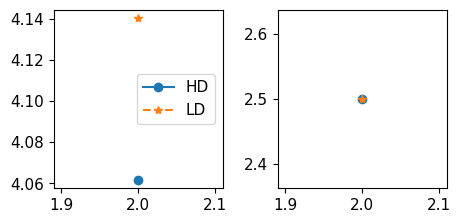

In [19]:
Cap_HD= []; Cap_LD = []; 
Vol_HD= []; Vol_LD = []; 
for i in [0]:#range(len(Rate_Dis_All)):
    Cap_HD.append(Get_cap(Sol_HD[i]))
    Cap_LD.append(Get_cap(Sol_LD[i]))
    Vol_HD.append(Get_vol(Sol_HD[i]))
    Vol_LD.append(Get_vol(Sol_LD[i]))
fig, axs = plt.subplots(1,2, figsize=(12/2.53,6/2.54),tight_layout=True)
axs[0].plot(Rate_Dis_All,Cap_HD,"-",marker = 'o',label="HD")
axs[0].plot(Rate_Dis_All,Cap_LD,"--",marker = '*',label="LD")
axs[1].plot(Rate_Dis_All,Vol_HD,"-",marker = 'o',label="HD")
axs[1].plot(Rate_Dis_All,Vol_LD,"--",marker = '*',label="LD")
axs[0].legend()

### new electrolyte and dLJP_d_ce: 1.82, 1.84, 1.86, 1.88

Case - Single, capacity under 1.8C discharge is 4.2047
Case - Double-Low $D_\times$,  capacity under 1.8C discharge is 4.2012
Case - Double-High $D_\times$,  capacity under 1.8C discharge is 4.1347

In [20]:
font = {'family' : 'DejaVu Sans','size'   : 11}
mpl.rc('font', **font)

In [21]:
# Quick plot: - Concentration - elely properties - voltage
Labels = [ r"Double-Low $D_\times$",r"Double-High $D_\times$"] #
var = [
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "EC:EMC wt%",

    "EC Lithium ion cross diffusivity [m2.s-1]",
    #"EC transference number",
    "Cation transference number",
    "Electrolyte conductivity [S.m-1]",
    "dLJP_dcEC",
    "dLJP_dce",
    
    "Battery voltage [V]",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_LD[-1].cycles[0].steps[1], 
        Sol_HD[-1].cycles[0].steps[1], 
        ], var,Labels,variable_limits='fixed',   
    time_unit='hours',n_rows=4) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.006990507323391031, description='t', max=0.42243446488742586, min=0.…

In [22]:
# Quick plot: - Voltage components
key_EC = [
    "EC concentration [mol.m-3]",
    "EC source term (SEI) [mol.m-3.s-1]",
    # "y_EC",
    "Minus div EC flux by diffusion [mol.m-3.s-1]",
    "Minus div EC flux by migration [mol.m-3.s-1]",
    "Minus div EC flux by Li+ [mol.m-3.s-1]",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_LD[-1].cycles[0].steps[1], 
        Sol_HD[-1].cycles[0].steps[1], 
        ], key_EC,Labels,variable_limits='fixed',   
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.006990507323391031, description='t', max=0.42243446488742586, min=0.…

In [23]:
# Quick plot: - Voltage components
Keys_t_var = [
    "Battery voltage [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_LD[0].cycles[0].steps[1], 
        Sol_HD[0].cycles[0].steps[1], 
        ], Keys_t_var,Labels,variable_limits='tight',   
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.006990507323391031, description='t', max=0.42243446488742586, min=0.…

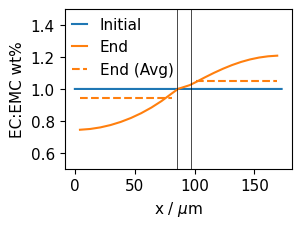

In [26]:
# plot solvent seg
fs=11
def Plot_Sol_Seg(sol,Rate_Dis,Ylim,Save_Fig,fig_name):
    Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
    step_i  =sol.cycles[0].steps[1]
    Y_0p = np.arange(-1,10,0.1); X_0 = np.arange(0,172.8,0.1)
    fig, axs = plt.subplots( figsize=(8/2.54,6.14/2.54), tight_layout=True) #
    y_ini = step_i["EC:EMC wt%"].entries[:,0]
    axs.plot( X_0,  np.mean(y_ini[0:20])*np.ones_like(X_0),  Colors[0],label="Initial")
    t_i = (step_i['Time [s]'].entries-step_i['Time [s]'].entries[0]).tolist()
    x =   step_i["x [m]"].entries[:,0]
    x_n =   step_i["x_n [m]"].entries[:,0]
    x_s =   step_i["x_p [m]"].entries[:,0]
    y =   step_i["EC:EMC wt%"].entries[:,-1]
    y_neg = np.mean(y[0:20]);
    y_pos = np.mean(y[-20:]);
    axs.plot(x*1e6,y,color=Colors[1],label="End") 
    axs.plot(
        x_n*1e6,y_neg* np.ones_like(x_n),
        color=Colors[1],linestyle="--",label="End (Avg)") 
    axs.plot(
        x_s*1e6,y_pos* np.ones_like(x_s),
        color=Colors[1],linestyle="--",) 
    axs.set_xlabel(r"x / $\mu$m",fontdict={'family':'DejaVu Sans','size':fs})
    #axs.set_title(Title_keys[i]) 
    axs.ticklabel_format( 
        axis='x', style='sci',
        scilimits=[-1e3,1e3], useOffset=None, 
        useLocale=None, useMathText=None)

    axs.set_ylabel("EC:EMC wt%")
    axs.plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
    axs.plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
    axs.legend(
        prop={'family':'DejaVu Sans','size':fs},
        markerscale=0.5,borderpad=0.0,
        handlelength=1.0,loc='best',frameon=False)  
    axs.set_ylim(Ylim)
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)

    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ f"{fig_name}.png", dpi=600)
        plt.savefig(BasicPath +  Target+ f"{fig_name}.svg")   
    return
Ylim = (0.5,1.5)
Rate_Dis = Rate_Dis_All[-1]
for i in [-1]:
    D_e_EC_cross = Para_DD[1]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_Sol_Seg(
        Sol_HD[i],Rate_Dis,Ylim,Save_Fig,
        fig_name=f"{Rate_Dis}C_1M_EC_EMC_wt%_D_e_EC_cross={D_e_EC_cross}") 
